# Perceptual decision making

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [28]:
def decision_making(I_init, rm, Cm, num, typeofconnect, prob_fixnum, diff_rate, diff_cur):
    U_rest = -0.065                
    U_reset = -0.065
    thresh = -0.050                      
    tau = Cm*rm

    T = 0.100 #total simulation length
    dt = 0.00002                    
    time = np.arange(0, T+dt, dt)      
  
    U = np.empty((1600,len(time)))   
    U[:,0] = U_rest                     
  
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((1600,len(time)))
  
    spikes = np.zeros((1600,len(time)))           
    act = []
    W , alpha = weights(typeofconnect,prob_fixnum,diff_rate)  

    for i in range(len(time)):
        for j in range(1600):
            I[j][i]= I_init[i] + I[j][i] + bool(j> 799)*I_init[i]/diff_cur
            U[j][i] = (((U_rest - U[j][i-1]) + I[j][i]*rm)*dt)/tau + U[j][i-1]
            if U[j][i] > thresh:
                U[j][i-1] = 0.04       
                U[j][i] = U_reset      
                spikes[j][i] =time[i] 
                act.append([i,j])
                if(i< 4997 and j< 800):
                    add_amount, minus_amount = I_values(j,i,I_init,time,spikes,W,alpha)
                    I[0:800,i+1:i+5] = I[0:800,i+1:i+5] + add_amount
                    I[800:1600,i+1:i+5] = I[800:1600,i+1:i+5] - minus_amount
                elif(i<4997 and j > 799):
                    add_amount, minus_amount = I_values(j,i,I_init,time,spikes,W,alpha)
                    I[0:800,i+1:i+5] = I[0:800,i+1:i+5] - minus_amount
                    I[800:1600,i+1:i+5] = I[800:1600,i+1:i+5] + add_amount
                    
                    
    return act , I_init , spikes

In [29]:
#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:5001] = I_init
    I1 = []
    I2 = []

    #Setting the initial current_ I1 
    for i in range(0, len(time)):
        
        var = gauss(I_init,I_init*0.1)
        I1.append(var)
    
    #Setting the initial current_ I2
    for i in range(0, len(time)):
        
        var = ((math.cos(i/100)+1)/4)*((math.sin(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I2.append(var)
   
    I = [I0,I1,I2]
    return I[num-1]

In [30]:
#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,alpha= None ,tau_I=0.001):
    k=j
    if j>799: k=j-800
        
    exp1= (time[i+1:i+5] - spikes[j][i])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp1 = np.dot(W[k,:].reshape(800,1),exp3.reshape(1,4))
    I_inp2 = np.dot(alpha[k,:].reshape(800,1),exp3.reshape(1,4))
    return I_inp1 , I_inp2

In [32]:
#compute the weights of connectivity due to type of connectivty.
def weights( typeofconnectivity = 'full' , prob_fixnum = 1, diff_rate = 150):
    
    w_EE = np.exp(np.random.normal(1,3,size=(800,800)))/70
    w_EI = np.exp(np.random.normal(0,2,size=(800,200)))/diff_rate
    w_IE = np.exp(np.random.normal(0,2,size=(200,800)))/diff_rate
    
    
        
    if( typeofconnectivity == 'full'):
        alpha = np.dot(w_EI,w_IE)/95
        w = (w_EE-alpha)/1000
        return w ,alpha
    
    if( typeofconnectivity == 'randomprob'):
        A_EE = sparse.random(800, 800, density=prob_fixnum, data_rvs=np.ones).toarray()
        A_EI = sparse.random(800, 200, density=prob_fixnum, data_rvs=np.ones).toarray()
        A_IE = sparse.random(200, 800, density=prob_fixnum, data_rvs=np.ones).toarray()
        alpha = np.dot(w_EI*A_EI,w_IE*A_IE)
        w = ( w_EE*A_EE-alpha )/(1000*prob_fixnum)
        return w ,alpha
    
    if( typeofconnectivity == 'randomfix'):
        alpha = np.dot(w_EI,w_IE)
        A_EE = np.zeros((800,800))
        A_alpha = np.zeros((800,800))
        for i in range(800):
            j = np.random.choice(list(range(800)), prob_fixnum, replace=False)
            k = np.random.choice(list(range(800)), prob_fixnum, replace=False)
            A_EE[i][j] = 1
            A_alpha[i][k] = 1
        
        alpha = np.dot(w_EI,w_IE)*A_alpha
        w = (w_EE*A_EE-alpha)/10
        return w,alpha

In [34]:
def simul_pop(I_init ,rm_init ,Cm_init, num, typeofconnect, prob_fixnum, diff_rate, diff_cur):
    act,I1,spike= decision_making(I_init, rm_init, Cm_init, num, typeofconnect, prob_fixnum, diff_rate, diff_cur)
    act = np.array(act)
    I2 = np.array(I1) + np.array(I1)/diff_cur
    
    
    color = np.where(act[:,1]>799,'r','b')
    
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("current", figsize=(20, 3))
    plt.title("current")
    plt.plot(np.arange(5001), I1, label="population1_current")
    plt.plot(np.arange(5001), I2, label="population2_current")
    plt.legend(loc="upper right")
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("Population activity of neurons", figsize=(20, 8))
    plt.title("Population activity of neurons")
    plt.scatter(act[:,0],act[:,1],marker='o',c = color , s=1)
    plt.ylabel("Number of neurons")
    plt.xlabel("Time [s]")

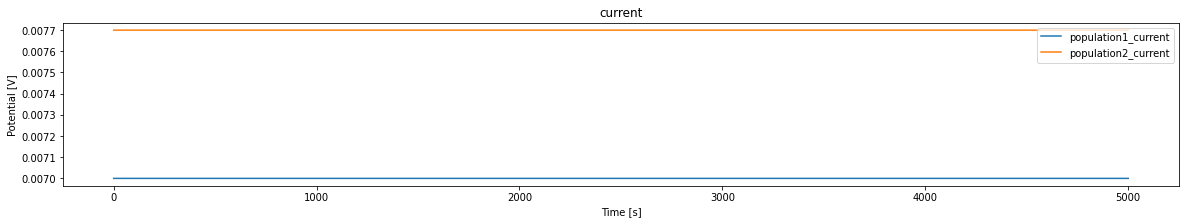

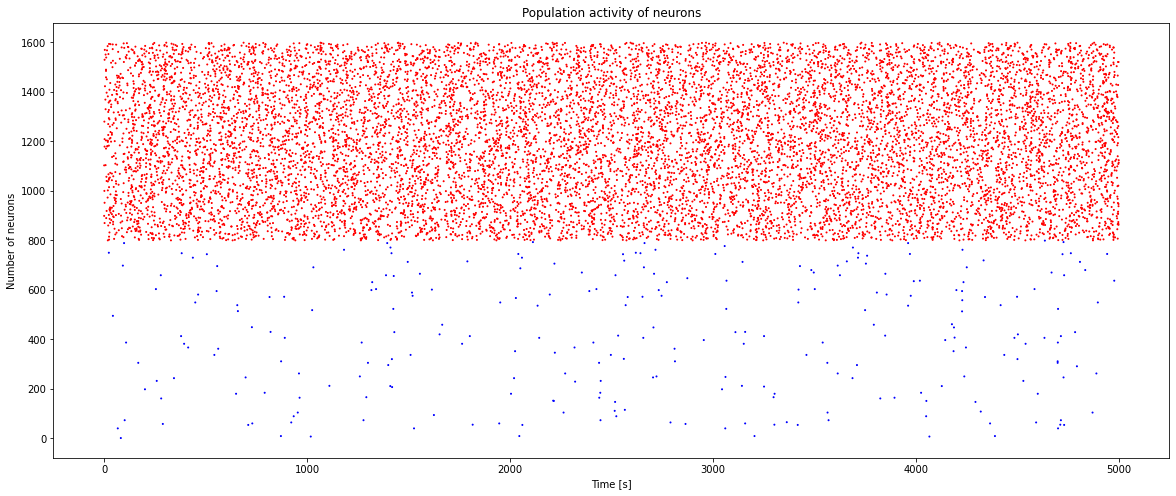

In [35]:
simul_pop(0.007 ,62.5,0.0049 ,1,'full' , 0.25, 150, 10 )

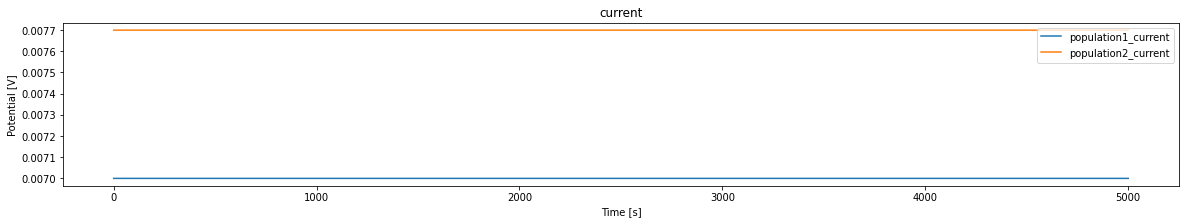

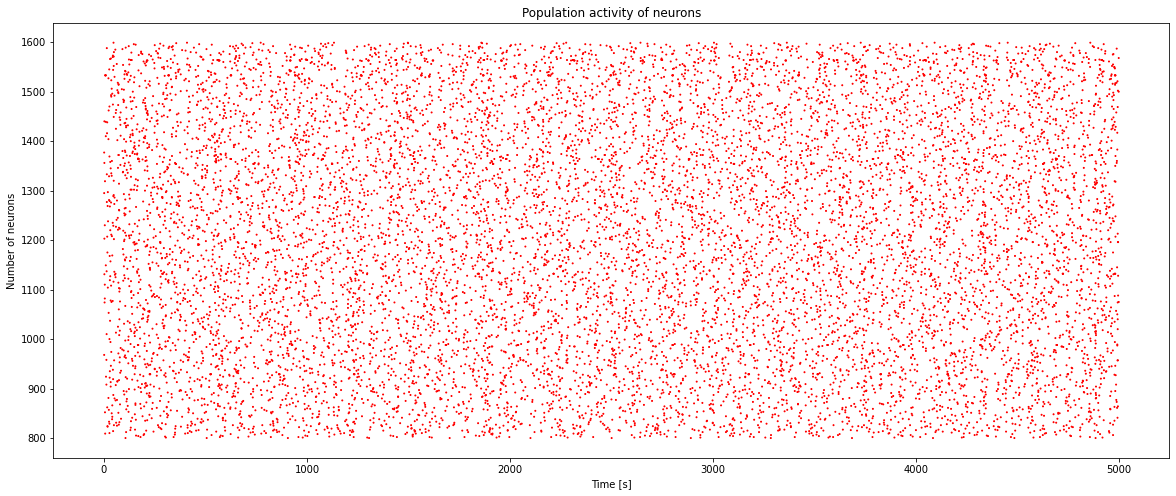

In [37]:
simul_pop(0.007 ,62.5,0.0049 ,1,'randomprob' , 0.25, 150, 10)

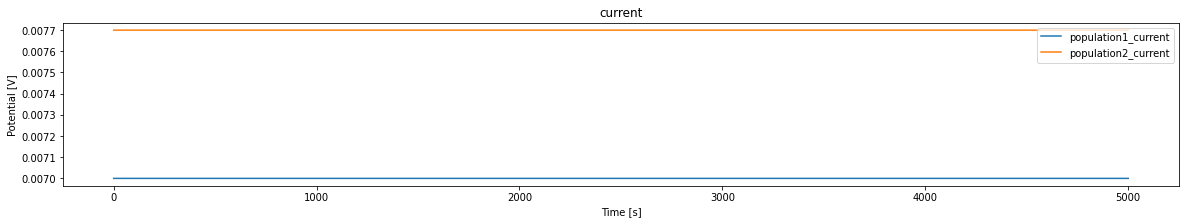

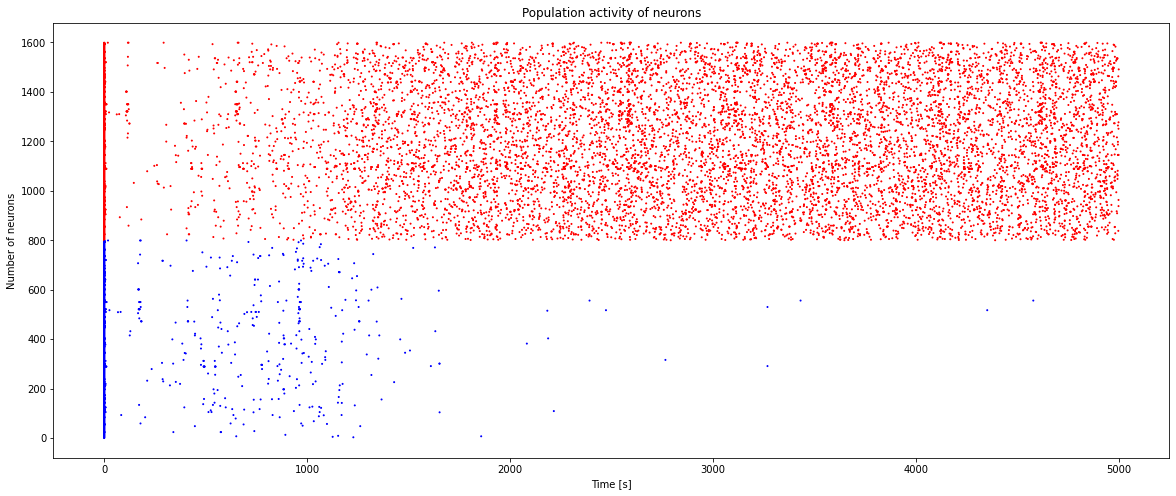

In [39]:
simul_pop(0.007 ,62.5,0.0049 ,1,'randomfix' ,  25, 150, 10)

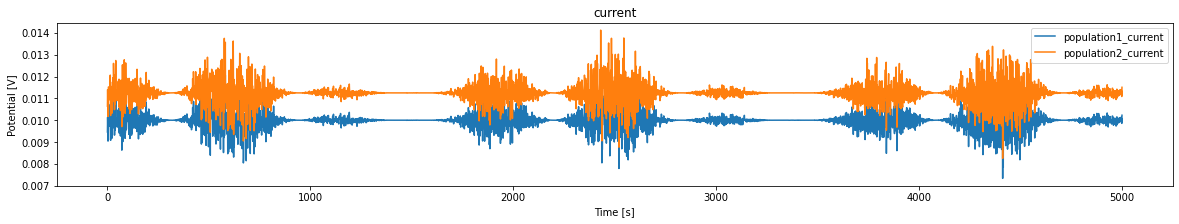

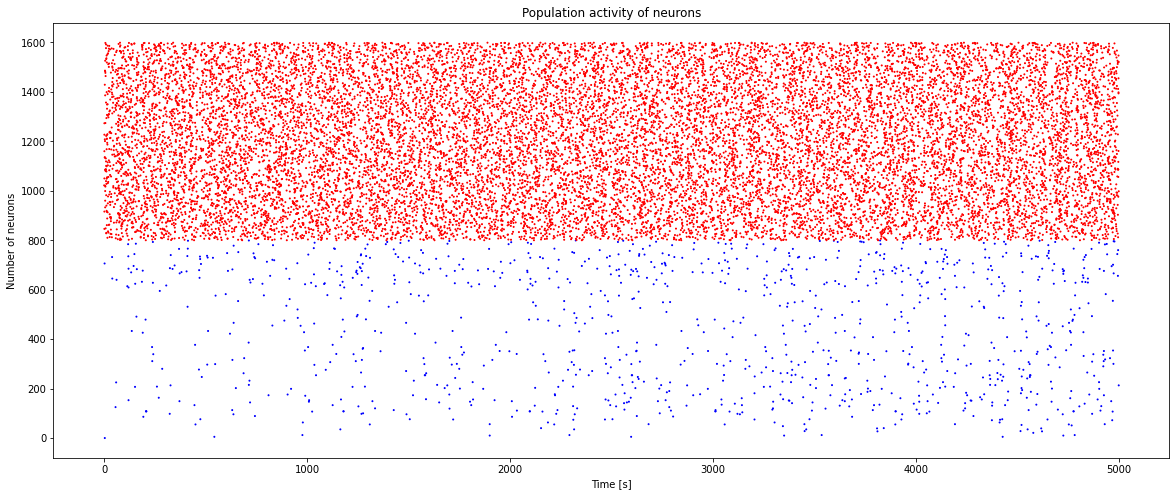

In [43]:
simul_pop(0.01 ,62.5,0.0049 ,3,'full' , 0.20, 150, 8 )

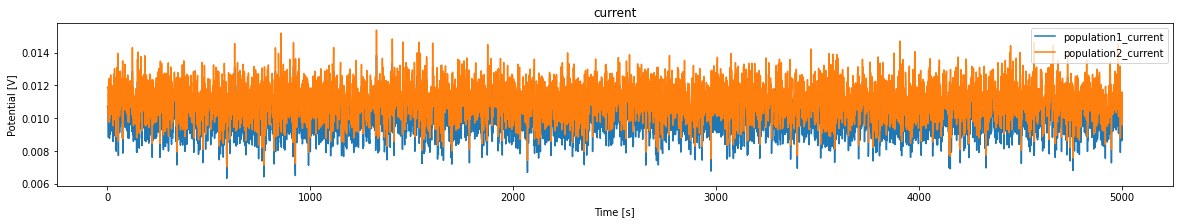

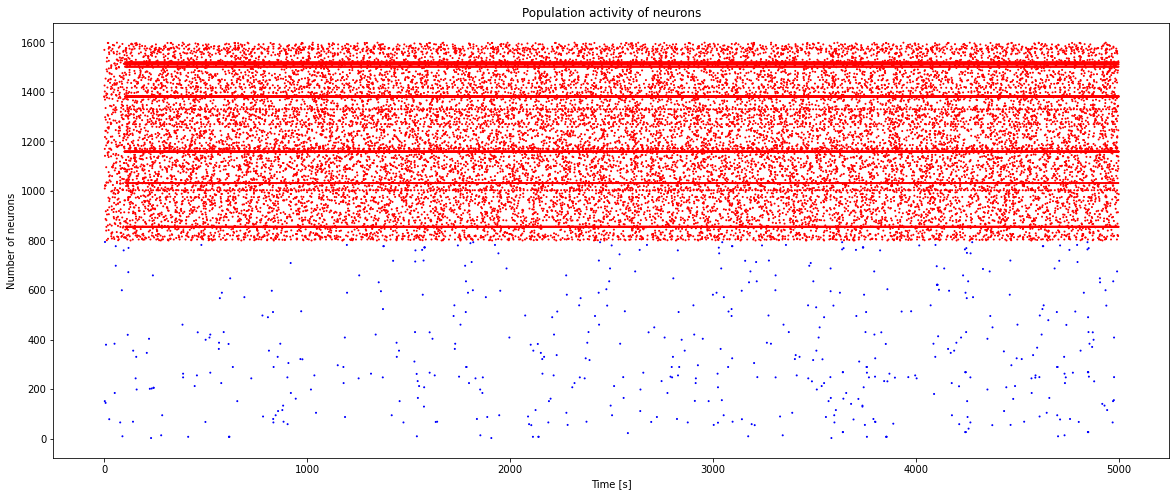

In [25]:
simul_pop(0.01 ,62.5,0.0049 ,2,'randomfix' , 20 , 210, 9)